In [7]:
import os, sys
sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))
import traci
import traci.constants as tc
import numpy as np
from sumolib import checkBinary
import datetime
import copy

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import optparse
import pandas as pd
import asyncio
from collections import namedtuple
import random
import matplotlib
import matplotlib.pyplot as plt

In [9]:
class NetworkA1(nn.Module):
    def __init__(self):
        super(NetworkA1, self).__init__()
        # [50, 60, 100, 0, .... , 20, 8]
        self.fc_layer1 = nn.Linear(10, 15) ##CHANGE!! 8
        self.fc_layer2 = nn.Linear(15, 20)
        self.fc_layer3 = nn.Linear(20, 9) ##CHANGE!! 2
        # S1 = [12, 13,24 ,56 , 0 1 0, 0 0 1]
        # 6= {0,1,2,3,4,5}
        # 7-8 
    def forward(self, x):
        # x is input
        # Layer 1
        x = F.relu(self.fc_layer1(x))
        # Layer 2
        x = F.relu(self.fc_layer2(x))
        # Layer 3
        x = self.fc_layer3(x)
        return x
model1 = NetworkA1()

In [10]:
#reset the environment
def reset():
    sumoBinary = checkBinary('sumo') #-gui
    traci.start([sumoBinary, "-c", "map_grid_lock_add2TL_copy.sumocfg",
                             "--tripinfo-output", "tripinfo.xml", '--start','true','--quit-on-end','true','--time-to-teleport','-1'])

In [11]:
id = {'virtual' : '270329335' ,'KasemRat': 'cluster_272448137_272555800_272555808_7660045934_7710268409'}
detecters = {'QA' : ['156261350#0'], 'QB' : ['-453962283#3'], 'QC' : ['459551209#0', '459551209#3'], 'QD' : ['27702347#0', '27702347#4', '27702347#6']}

In [12]:
import sumolib
import lxml.etree as ET
def get_edge_id(POI):
#     root = ET.Element('additionals')
#     net = sumolib.net.readNet('map_grid_lock_add2TL_copy_newTLS.net.xml')
#     output = []
#     for key in POI:
#         edgeID = net.getEdge(key)
#         numOfLane = edgeID.getLaneNumber()
#         for lane_index in range(numOfLane):
#             output.append(key+'_'+str(lane_index))
#     print(output)
    if POI == ['156261350#0']:
        output = ['156261350#0_0']
    if POI == ['-453962283#3']:
        output = ['-453962283#3_0']
    if POI == ['459551209#0', '459551209#3']:
        output = ['459551209#0_0', '459551209#0_1', '459551209#0_2', '459551209#0_3', '459551209#3_0', '459551209#3_1', '459551209#3_2', '459551209#3_3']
    if POI == ['27702347#0', '27702347#4', '27702347#6']:
        output = ['27702347#0_0', '27702347#4_0', '27702347#6_0']
    return output    

In [13]:
def get_state():
    occupancy = []
    for key in ['QA', 'QB', 'QC', 'QD']:
        occupancy.append(sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(detecters[key])])/len(get_edge_id(detecters[key])))
    current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
    for i in current_phase:
        current_phase_binary = [0, 0, 0]
        current_phase_binary[int(i//2)] = 1
        occupancy+= current_phase_binary
    return occupancy

In [14]:
reward_memory = []
def plot_durations():
    print('show')
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_memory, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [15]:
def take_action(action, ID):
    if ID in [0,1]:
        action = action-6
        w = 0.999
        act = [5, 1, 3]
        print(act[action])
        change_to_phase = (act[action]+1)%6
        if change_to_phase == traci.trafficlight.getPhase(id[junction_name[ID]]):
            traci.trafficlight.setPhase(id[junction_name[ID]], change_to_phase) # NO YELLOW PHASE 
        else:
            traci.trafficlight.setPhase(id[junction_name[ID]], act[action]) # YELLOW PHASE FIRST
    for i in range(5):
        traci.simulationStep()
#     w1 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     w2 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     reward = -w2*(1-w) - w1*(w)
    reward = -sum(get_state())
    print('reward', reward)
    next_state1 = get_state()
    junction, action = get_action(next_state1)
    return reward, next_state1

In [16]:
def get_action(current_state):
    if np.random.rand() < epsilon:
        junction = np.random.randint(5)
        action = np.random.randint(2)
    else:
        # Ask model what to do?        
        answer = policy_net1(torch.tensor(current_state))
        junction = torch.argmax(answer[0:6])
        action = torch.argmax(answer[6:9])
    return junction, action+6

In [17]:
def initial(state1, max_occupancy):
    occupancy = copy.deepcopy(state1[0:4])
    print(occupancy)
    s1 = copy.deepcopy(state1[4:7])
    s2 = copy.deepcopy(state1[7:9])
    if state1 == None and state2 == None:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            traci.trafficlight.setPhase(id['virtual'], 2)
            junction = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junction = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junction = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            junction = 1
            action = 0
    else:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            traci.trafficlight.setPhase(id['virtual'], 2)
            junct = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            junct = 1
            action = 0
    for i in range(5):
        traci.simulationStep()
    reward = -sum(get_state())
    next_state1 = get_state()
    
    return reward, state1, action, junct, next_state1

In [18]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [25]:
def optimize_model1():
    if len(memory1) < BATCH_SIZE:
        return

    transitions = memory1.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_mask = non_final_mask.reshape(1,-1).t()
    non_final_mask = torch.cat((non_final_mask,non_final_mask),1).detach() 
    
    print('non_final_mask', non_final_mask)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    print('non_final_next_states',  non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    print('state_batch', state_batch)
    print('reward_batch', reward_batch)
    print('action_batch', action_batch)
    print('policy_net1(state_batch)', policy_net1(state_batch))
    state_action_values = policy_net1(state_batch).gather(1, action_batch)
    print('state_action_values', state_action_values)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    A = target_net1(non_final_next_states).detach().numpy()
    print('A', A)
    J = torch.tensor(A[:,[0,1,2,3,4,5]]).max(1)[0]
    print('J', J)
    P = torch.tensor(A[:,[6,7,8]]).max(1)[0]
    print('P', P)

    next_state_values = torch.cat((J.reshape(1,-1).t(),P.reshape(1,-1).t()),1).detach() 
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    print('expected_state_action_values ', expected_state_action_values )

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values) #.unsqueeze(1)

    # Optimize the model
    optimizer1.zero_grad()
    loss.backward()
    for param in policy_net1.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer1.step()

In [26]:
A = target_net1(torch.tensor([[2.8533, 0.0000, 7.0294, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.3356, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [1.4266, 0.0000, 7.3610, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.1284, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000]])).detach().numpy()
J = torch.tensor(A[:,[0,1,2,3,4,5]]).max(1)[0]
P = torch.tensor(A[:,[6,7,8]]).max(1)[0]

print(torch.cat((J.reshape(1,-1).t(),P.reshape(1,-1).t()),1))

non = torch.tensor([[True],
        [True],
        [True],
        [True],
        [True]])


tensor([[-100.2180, -129.0053],
        [ -63.2683,  -81.6236],
        [ -79.6158, -102.7542],
        [ -91.3935, -117.7884],
        [ -53.0772,  -68.4507]])


In [27]:
junction_name = ['virtual','KasemRat']

time_step = 5
reward = 0 
epsilon = 0.1 # ดมกาว 10%
GAMMA = 0.9  #GAMMA = [e for e in gamma()] ภีมเปลี่ยนเอาเองนะถ้าอยากเปลี่ยน

action = 0
current_state1 = None
previous_state1 = None

memory = []
BATCH_SIZE =5 

start_training_step = 10
current_training_step = 0 

alpha = 0.1

# create your optimizer
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)

criterion = nn.MSELoss()

policy_net1 = model1
target_net1 = model1
target_net1.load_state_dict(policy_net1.state_dict())
target_net1.eval()
optimizer1 = optim.RMSprop(policy_net1.parameters())


memory1 = ReplayMemory(10000)

TARGET_UPDATE = 10

steps_done = 0

In [28]:
traci.close()

In [29]:
# #episode = 0
# state1 = None
# rewards = 0
# reset()
# traci.simulationStep()
# state1 = get_state()
# for seconds in range(100):
#     reward, current_state1, action, junction, next_state1 = initial(state1, 50)
#     if state1 is not None :
#         memory1.push(torch.tensor([current_state1]), torch.tensor([[junction, action]]), torch.tensor([next_state1]), torch.tensor([reward]))
#     state1 = next_state1
#     optimize_model1()
#     rewards += reward
# reward_memory.append(rewards)
# traci.close()

reward -3.5828422639440864
reward -3.7268138561220767
reward -4.687999665149713
reward -4.290023652316296
reward -6.76724704198075
reward -7.868501523473141
non_final_mask tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])
non_final_next_states tensor([[1.4266, 0.0000, 3.3406, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.6880, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [1.4266, 1.7539, 2.6880, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.2900, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.7268, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000]])
state_batch tensor([[0.0000, 0.0000, 2.2900, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.7268, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
       

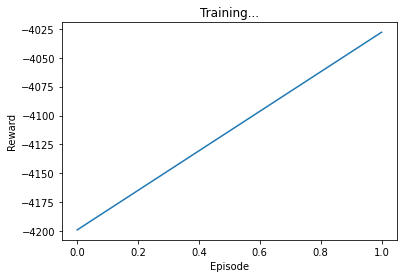

1
reward -3.5828422639440864
non_final_mask tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])
non_final_next_states tensor([[11.4130,  6.4395, 18.7790, 15.3735,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [12.3440,  3.2197, 24.5665, 10.5098,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [ 7.1332,  3.2197,  7.6612, 10.9589,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000],
        [ 9.9864,  3.2197,  4.3327,  8.5990,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000],
        [ 7.1332,  6.4395,  5.4118, 14.2193,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000]])
state_batch tensor([[ 9.9864,  6.4395, 17.3845,  9.2981,  1.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [11.4130,  3.2197, 21.8606, 12.2717,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [ 7.1332,  3.2197, 10.0480, 13.3824,  0

In [ ]:
# async def run():
for episode in range(100):
    rewards = 0
    count = 0
    reset()
    traci.simulationStep()
    previous_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#     print(previous_phase)
    for seconds in range(100): 
#         traci.simulationStep()
#             if seconds >= 300: ??
#         if seconds%time_step == 0:
#             if done(count) >= 50:
#                 print('done')
#                 break
        current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#             print('current_phase', current_phase)
        current_state1 = get_state()
#             print('current_state1', current_state1)
        junction, action = get_action(current_state1)
#         print('junction', junction)
#         print('action', action)
        reward, next_state1 = take_action(action, junction) 
        if previous_state1 is not None:
            memory1.push(torch.tensor([current_state1]), torch.tensor([[junction, action]]), torch.tensor([next_state1]), torch.tensor([[reward]]))
        optimize_model1()
        previous_state1 = current_state1
        rewards += reward
    reward_memory.append(rewards)
    plot_durations()

    if episode % TARGET_UPDATE == 0:
        target_net1.load_state_dict(policy_net1.state_dict())
    traci.close()

print('Complete')
plt.ioff()
plt.show()